# Gender Classification using Dimensionality Reduction and Clustering

This notebook implements a facial gender classification system using several dimensionality reduction techniques (PCA, LDA, CCA) and clustering methods. The analysis explores different approaches for representing facial images and classifying them by gender.

## 1. Import Required Libraries

In [1]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve)
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

## 2. Set Up Environment

Configuring plotting styles and setting up the environment for analysis.

In [2]:
# Set plot style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Debug: confirm working directory and files
print("Working directory:", os.getcwd())
print("Directory contents:", os.listdir())

# Create results directory if it doesn't exist
results_dir = "visualization_results"
os.makedirs(results_dir, exist_ok=True)

Working directory: F:\OneDrive - University of Patras\CEID\10ο Εξάμηνο\ΕΦΑΡΜΟΓΕΣ ΨΗΦΙΑΚΗΣ ΕΠΕΞΕΡΓΑΣΙΑΣ ΣΗΜΑΤΩΝ\ASKISI 4\ADSP_4-LDA
Directory contents: ['ADSP_PCA_LDA_k_means_cor.pdf', 'classification_results', 'faces_dataset', 'face_classification.ipynb', 'face_classification.py', 'gender_classification.ipynb', 'gender_classification.py', 'gender_map.json', 'make_splits.py', 'person_recognition_results', 'person_splits.json', 'report template.docx', 'report template.pdf', 'splits.json', 'test_json_load.py', 'visualization_results']


## 3. Load Data

Loading image data from the splits.json file which contains paths to facial images and their gender labels.

In [3]:
# Load splits.json
with open("splits.json", "r") as f:
    splits = json.load(f)

# Define function to load data sets
def load_set(key):
    X, y = [], []
    for e in splits[key]:
        img = np.array(Image.open(e["path"]), dtype=float).flatten()
        X.append(img)
        y.append(e["label"])
    return np.vstack(X), np.array(y)

# Load train and test sets
X_train, y_train = load_set("train")
X_test, y_test = load_set("test")

# Get original image dimensions
first_img = Image.open(splits["train"][0]["path"])
width, height = first_img.size
print(f"Image dimensions: {width}x{height}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Image dimensions: 92x112
Training samples: 280
Testing samples: 120


## 4. Preprocess Data

Centering the data by subtracting the mean face and encoding labels for different analyses.

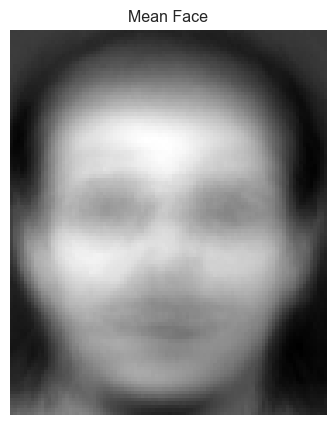

Classes: ['female' 'male']
Class distribution in training set: [ 28 252]
Class distribution in test set: [ 12 108]


In [4]:
# Compute mean face and center data
mean_face = X_train.mean(axis=0)
X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face

# Display mean face
plt.figure(figsize=(5, 5))
plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

# Encode labels for CCA and visualization
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train).reshape(-1, 1)
y_test_enc = le.transform(y_test).reshape(-1, 1)
y_train_num = le.transform(y_train)
y_test_num = le.transform(y_test)

print(f"Classes: {le.classes_}")
print(f"Class distribution in training set: {np.bincount(y_train_num)}")
print(f"Class distribution in test set: {np.bincount(y_test_num)}")

## 5. PCA Analysis

Principal Component Analysis (PCA) is a dimensionality reduction technique that finds orthogonal directions of maximum variance in the data. We'll use it to reduce the dimensionality of our facial images while preserving as much variance as possible.


=== PCA Analysis ===


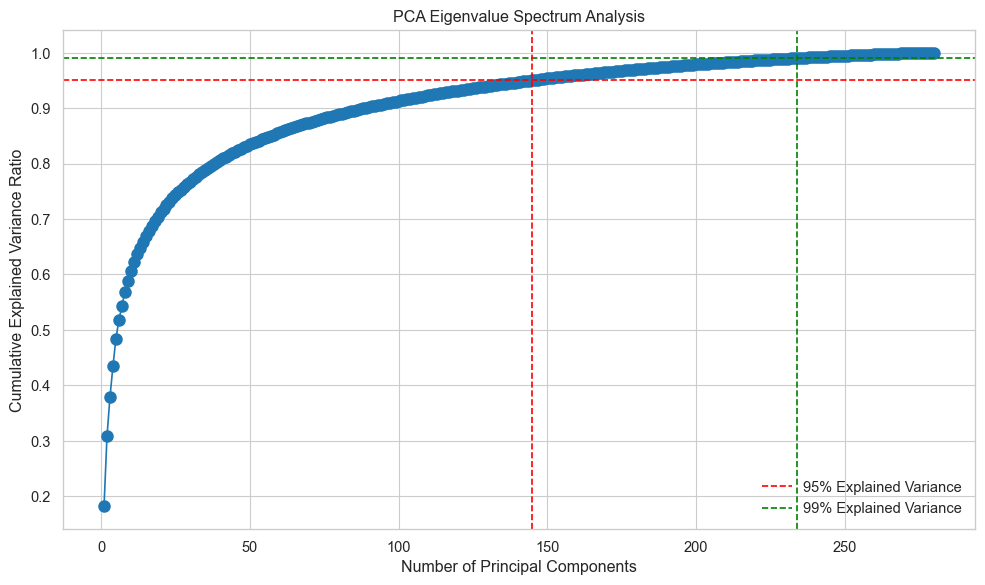

Components needed for 95% variance: 145
Components needed for 99% variance: 234


In [5]:
print("\n=== PCA Analysis ===")
n_components_full = min(X_train.shape[0], X_train.shape[1])
pca_full = PCA(n_components=n_components_full)
pca_full.fit(X_train_centered)

# Eigenvalue Spectrum Visualization
plt.figure(figsize=(10, 6))
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
plt.plot(range(1, len(explained_var) + 1), cumulative_var, 'o-', markersize=8)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance')
components_95 = np.where(cumulative_var >= 0.95)[0][0] + 1
components_99 = np.where(cumulative_var >= 0.99)[0][0] + 1
plt.axvline(x=components_95, color='r', linestyle='--')
plt.axvline(x=components_99, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Eigenvalue Spectrum Analysis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Components needed for 95% variance: {components_95}")
print(f"Components needed for 99% variance: {components_99}")

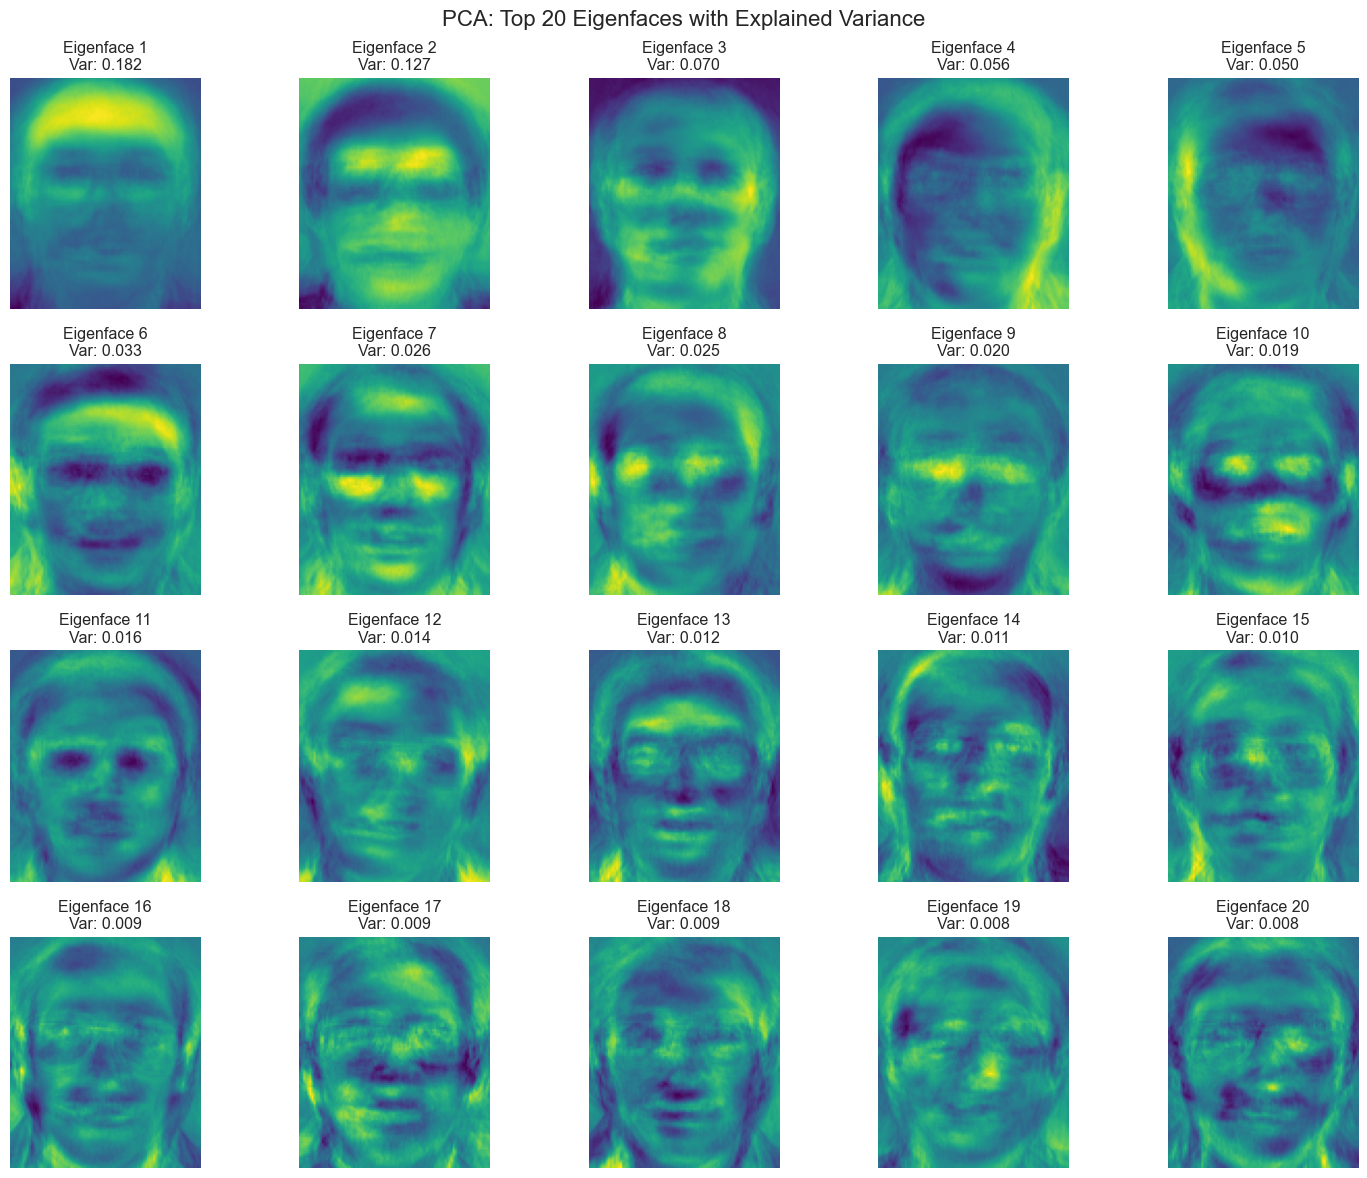

In [6]:
# Top Eigenfaces visualization
n_eigenfaces = 20
pca = PCA(n_components=n_eigenfaces, svd_solver="randomized", whiten=True)
Z_train = pca.fit_transform(X_train_centered)
Z_test = pca.transform(X_test_centered)

# Eigenfaces grid
eigs = pca.components_.reshape((n_eigenfaces, height, width))
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    if i < n_eigenfaces:
        ax.imshow(eigs[i], cmap="viridis")
        ax.set_title(f"Eigenface {i + 1}\nVar: {pca.explained_variance_ratio_[i]:.3f}")
        ax.axis("off")
    else:
        ax.axis("off")
plt.suptitle("PCA: Top 20 Eigenfaces with Explained Variance", fontsize=16)
plt.tight_layout()
plt.show()

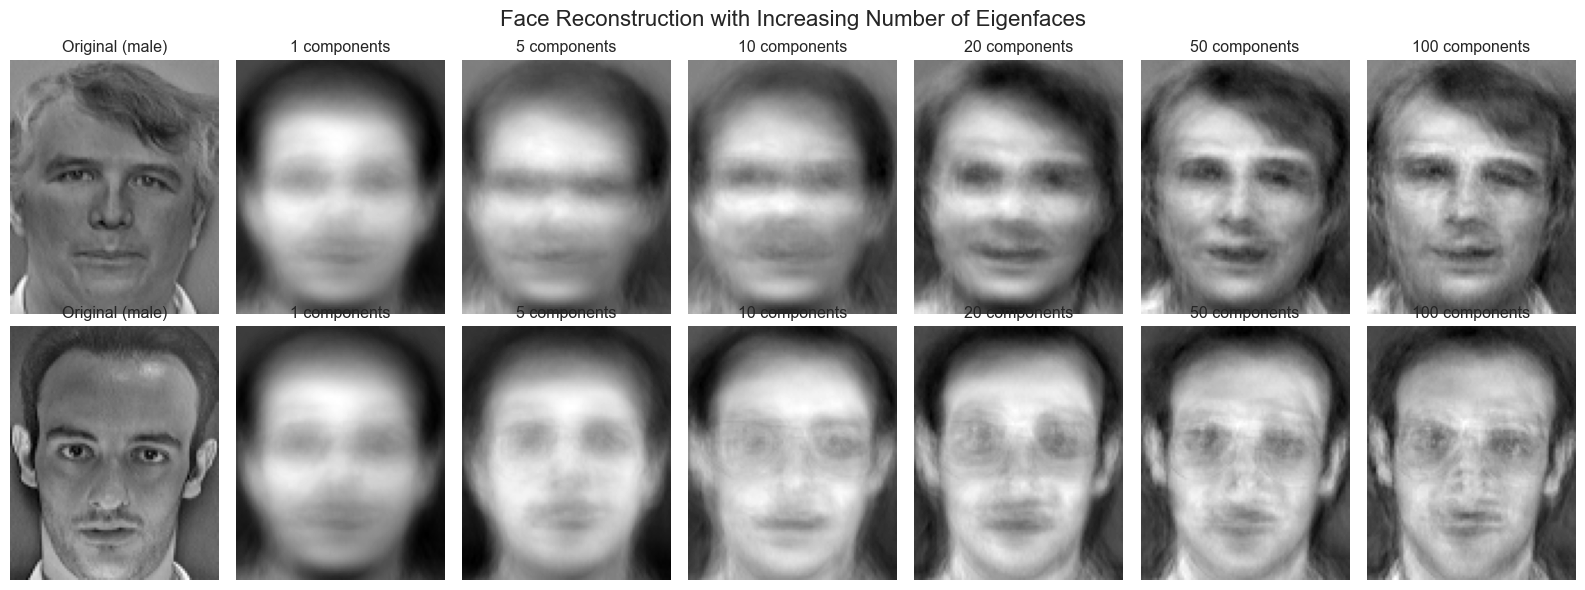

In [7]:
# Face reconstruction with increasing eigenfaces
n_reconstructions = 2  # Number of faces to reconstruct (reduced for display purposes)
reconstruction_steps = [1, 5, 10, 20, 50, 100]  # Number of eigenfaces to use

# Get some test faces
np.random.seed(42)  # For reproducibility
test_faces_indices = np.random.choice(len(X_test), n_reconstructions, replace=False)
test_faces = X_test_centered[test_faces_indices]
test_labels = y_test[test_faces_indices]

# Create a larger PCA model for reconstruction
if max(reconstruction_steps) > n_eigenfaces:
    pca_recon = PCA(n_components=max(reconstruction_steps))
    pca_recon.fit(X_train_centered)
else:
    pca_recon = pca

# Plot reconstructions
fig, axes = plt.subplots(n_reconstructions, len(reconstruction_steps) + 1,
                       figsize=(16, 3 * n_reconstructions))

for i, face_idx in enumerate(range(n_reconstructions)):
    # Original face
    orig_face = test_faces[face_idx].reshape(height, width)
    axes[i, 0].imshow(orig_face, cmap='gray')
    axes[i, 0].set_title(f"Original ({test_labels[face_idx]})")
    axes[i, 0].axis('off')

    # Reconstructions with increasing eigenvectors
    for j, n_components in enumerate(reconstruction_steps):
        # Project to eigenspace and back
        reduced = pca_recon.transform(test_faces[face_idx].reshape(1, -1))[:, :n_components]
        reconstructed = np.dot(reduced, pca_recon.components_[:n_components, :]) + mean_face
        reconstructed = reconstructed.reshape(height, width)

        # Display reconstruction
        axes[i, j + 1].imshow(reconstructed, cmap='gray')
        axes[i, j + 1].set_title(f"{n_components} components")
        axes[i, j + 1].axis('off')

plt.suptitle("Face Reconstruction with Increasing Number of Eigenfaces", fontsize=16)
plt.tight_layout()
plt.show()

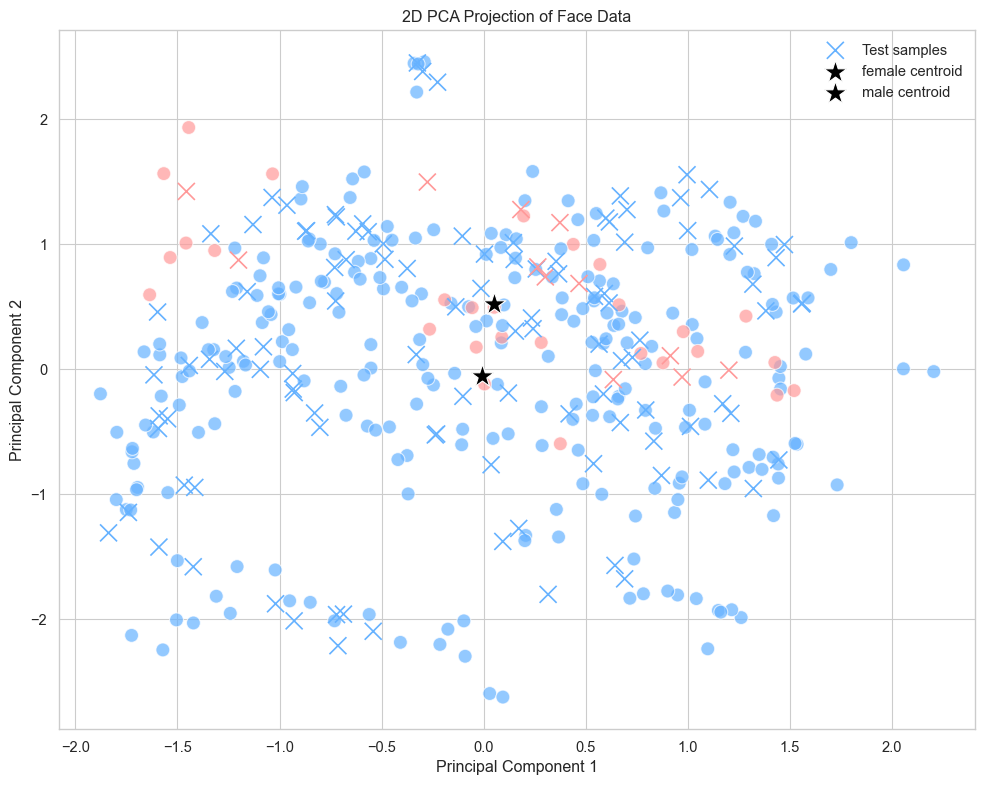

PCA + 1-NN Accuracy: 1.0000


In [8]:
# 2D visualization of PCA-projected face data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train_num,
                    cmap=ListedColormap(['#FF9999', '#66B2FF']),
                    s=100, alpha=0.7, edgecolors='w')
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_test_num,
          cmap=ListedColormap(['#FF9999', '#66B2FF']),
          marker='x', s=150, label='Test samples')

# Add centroids
for i, gender in enumerate(le.classes_):
    centroid = np.mean(Z_train[y_train == gender, :2], axis=0)
    plt.scatter(centroid[0], centroid[1], s=300, c='black',
                marker='*', label=f'{gender} centroid', edgecolors='w')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection of Face Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train a 1-NN classifier on the PCA projection
knn_pca = KNeighborsClassifier(n_neighbors=1).fit(Z_train, y_train)
pred_pca = knn_pca.predict(Z_test)
pca_accuracy = accuracy_score(y_test, pred_pca)
print(f"PCA + 1-NN Accuracy: {pca_accuracy:.4f}")

## 6. LDA Analysis

Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that finds directions that maximize the separation between classes while minimizing the variation within each class.


=== LDA Analysis ===


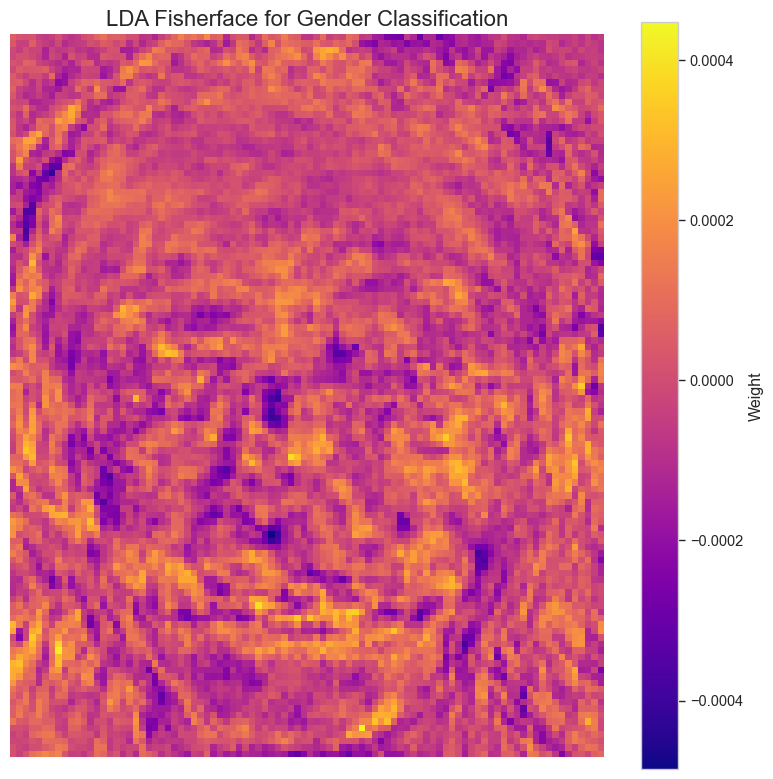

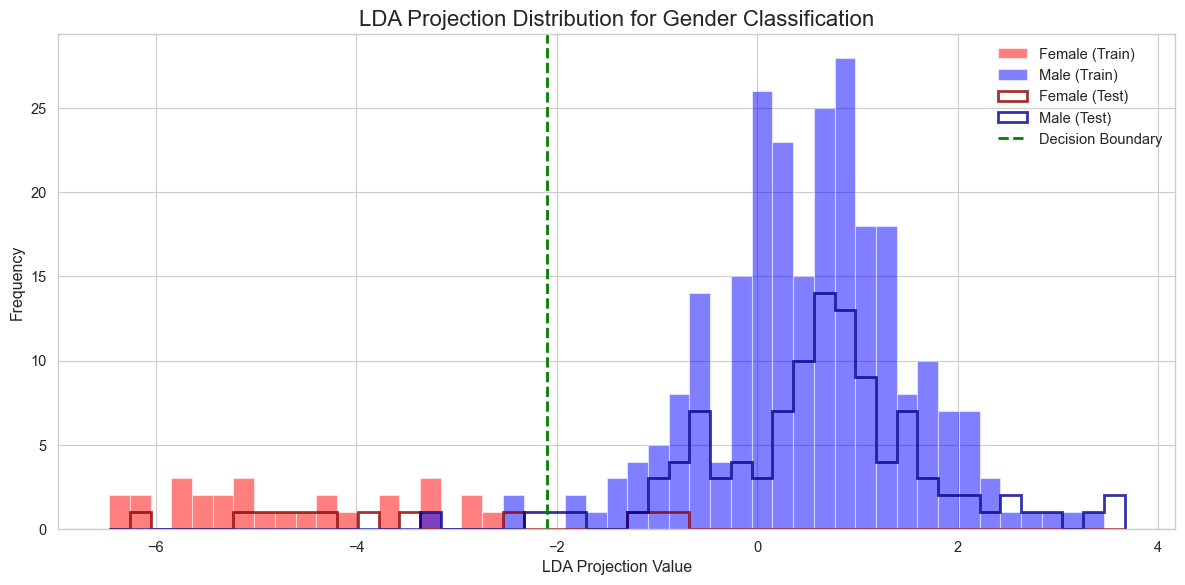

LDA + 1-NN Accuracy: 0.9500


In [9]:
print("\n=== LDA Analysis ===")
lda = LinearDiscriminantAnalysis(n_components=1)
L_train = lda.fit_transform(X_train_centered, y_train)
L_test = lda.transform(X_test_centered)

# Visualize the Fisherface
fisherface = lda.scalings_[:, 0].reshape((height, width))
plt.figure(figsize=(8, 8))
plt.imshow(fisherface, cmap="plasma")
plt.title("LDA Fisherface for Gender Classification", fontsize=16)
plt.axis("off")
plt.colorbar(label='Weight')
plt.tight_layout()
plt.show()

# Visualize LDA projection
plt.figure(figsize=(12, 6))
bins = np.linspace(min(np.min(L_train), np.min(L_test)),
                 max(np.max(L_train), np.max(L_test)), 50)

plt.hist(L_train[y_train == 'female'], bins=bins, alpha=0.5, color='red',
       label='Female (Train)')
plt.hist(L_train[y_train == 'male'], bins=bins, alpha=0.5, color='blue',
       label='Male (Train)')

plt.hist(L_test[y_test == 'female'], bins=bins, alpha=0.8, color='darkred',
       label='Female (Test)', histtype='step', linewidth=2)
plt.hist(L_test[y_test == 'male'], bins=bins, alpha=0.8, color='darkblue',
       label='Male (Test)', histtype='step', linewidth=2)

# Decision boundary
threshold = (np.mean(L_train[y_train == 'female']) + np.mean(L_train[y_train == 'male'])) / 2
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2,
          label='Decision Boundary')

plt.xlabel('LDA Projection Value')
plt.ylabel('Frequency')
plt.title('LDA Projection Distribution for Gender Classification', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Train a 1-NN classifier on the LDA projection
knn_lda = KNeighborsClassifier(n_neighbors=1).fit(L_train, y_train)
pred_lda = knn_lda.predict(L_test)
lda_accuracy = accuracy_score(y_test, pred_lda)
print(f"LDA + 1-NN Accuracy: {lda_accuracy:.4f}")

## 7. Centroid Classifier

A simple classifier that computes the centroid (mean) of each class in the training set and assigns new samples to the class with the nearest centroid.


=== Centroid Classifier Analysis ===


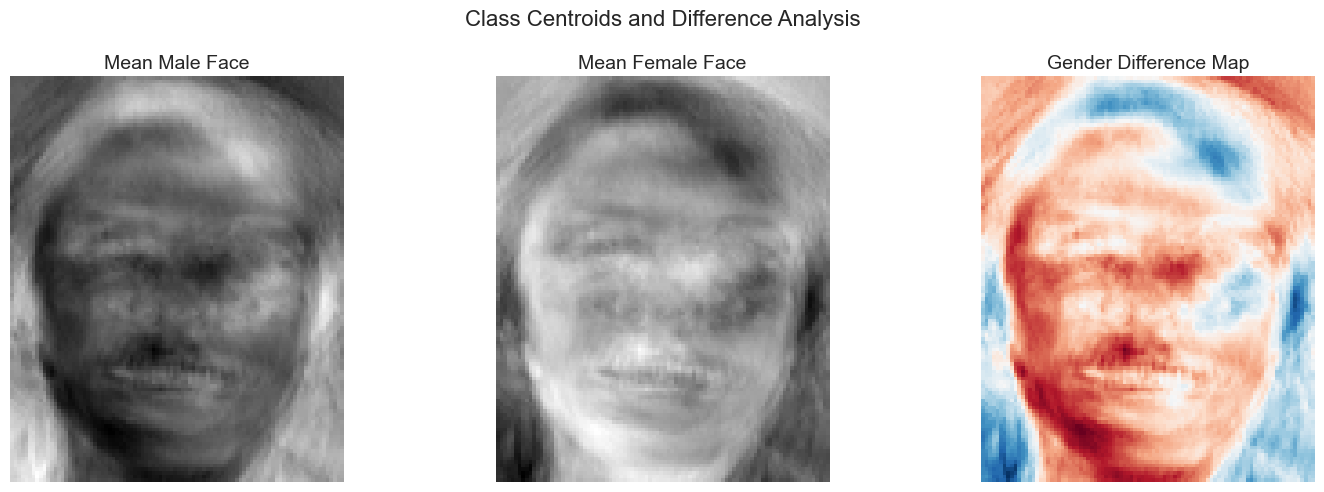

Centroid Classifier Accuracy: 0.8583


In [10]:
print("\n=== Centroid Classifier Analysis ===")
male_centroid = X_train_centered[y_train == "male"].mean(axis=0)
female_centroid = X_train_centered[y_train == "female"].mean(axis=0)

# Visualize class mean faces (centroids)
male_mean_face = male_centroid.reshape((height, width))
female_mean_face = female_centroid.reshape((height, width))
diff_face = (female_mean_face - male_mean_face)
normalized_diff = (diff_face - diff_face.min()) / (diff_face.max() - diff_face.min())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(male_mean_face, cmap="gray")
axes[0].set_title("Mean Male Face", fontsize=14)
axes[0].axis("off")

axes[1].imshow(female_mean_face, cmap="gray")
axes[1].set_title("Mean Female Face", fontsize=14)
axes[1].axis("off")

axes[2].imshow(normalized_diff, cmap="RdBu_r")
axes[2].set_title("Gender Difference Map", fontsize=14)
axes[2].axis("off")

plt.suptitle("Class Centroids and Difference Analysis", fontsize=16)
plt.tight_layout()
plt.show()

# Define prediction function for centroid classifier
def predict_centroid(X):
    d_m = np.linalg.norm(X - male_centroid, axis=1)
    d_f = np.linalg.norm(X - female_centroid, axis=1)
    return np.where(d_m < d_f, "male", "female")

# Evaluate centroid classifier
pred_centroid = predict_centroid(X_test_centered)
centroid_accuracy = accuracy_score(y_test, pred_centroid)
print(f"Centroid Classifier Accuracy: {centroid_accuracy:.4f}")

## 8. K-means Clustering

K-means is an unsupervised learning algorithm that partitions data into k clusters, where each data point belongs to the cluster with the nearest mean. We'll apply it to the PCA-projected data.

In [12]:
print("\n=== K-means Clustering Analysis ===")

# Apply k-means to PCA-projected data
n_clusters = 2  # For gender classification
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_pca.fit(Z_train)

# Define function to run k-means with history tracking (for visualization of convergence)
def run_kmeans_with_history(X, n_clusters, max_iters=10):
    # Initialize centroids
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)
    centroids = X[indices]

    history = [centroids.copy()]
    labels_history = []
    inertia_history = []

    for iteration in range(max_iters):
        # Assign labels based on closest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis]) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        labels_history.append(labels.copy())

        # Calculate inertia
        inertia = 0
        for i in range(n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[i]) ** 2)
        inertia_history.append(inertia)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0
                                  else centroids[i] for i in range(n_clusters)])

        # Check for convergence
        if np.allclose(new_centroids, centroids):
            history.append(new_centroids.copy())
            break

        centroids = new_centroids
        history.append(centroids.copy())

    return history, labels_history, inertia_history


# Use the first 2 PCA components for visualization
X_pca_2d = Z_train[:, :2]
centroid_history, labels_history, inertia_history = run_kmeans_with_history(X_pca_2d, n_clusters)

# Evaluate k-means clusters against true labels
pca_clusters = kmeans_pca.predict(Z_train)
contingency_table = confusion_matrix(y_train_num, pca_clusters)

# We need to align cluster labels with true labels (since k-means is unsupervised)
if contingency_table[0, 0] + contingency_table[1, 1] < contingency_table[0, 1] + contingency_table[1, 0]:
    # Swap cluster labels if they're inverted
    pca_clusters = 1 - pca_clusters

print("K-means Clustering Evaluation:")
print(confusion_matrix(y_train_num, pca_clusters))
print(f"Clustering accuracy: {accuracy_score(y_train_num, pca_clusters):.4f}")

# Apply k-means to LDA projection
kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_lda.fit(L_train)
lda_clusters = kmeans_lda.predict(L_train)

# Align cluster labels with true labels
contingency_table = confusion_matrix(y_train_num, lda_clusters)
if contingency_table[0, 0] + contingency_table[1, 1] < contingency_table[0, 1] + contingency_table[1, 0]:
    lda_clusters = 1 - lda_clusters

print("\nLDA K-means Clustering Evaluation:")
print(confusion_matrix(y_train_num, lda_clusters))
print(f"Clustering accuracy: {accuracy_score(y_train_num, lda_clusters):.4f}")


=== K-means Clustering Analysis ===
K-means Clustering Evaluation:
[[ 23   5]
 [ 97 155]]
Clustering accuracy: 0.6357

LDA K-means Clustering Evaluation:
[[ 28   0]
 [  3 249]]
Clustering accuracy: 0.9893


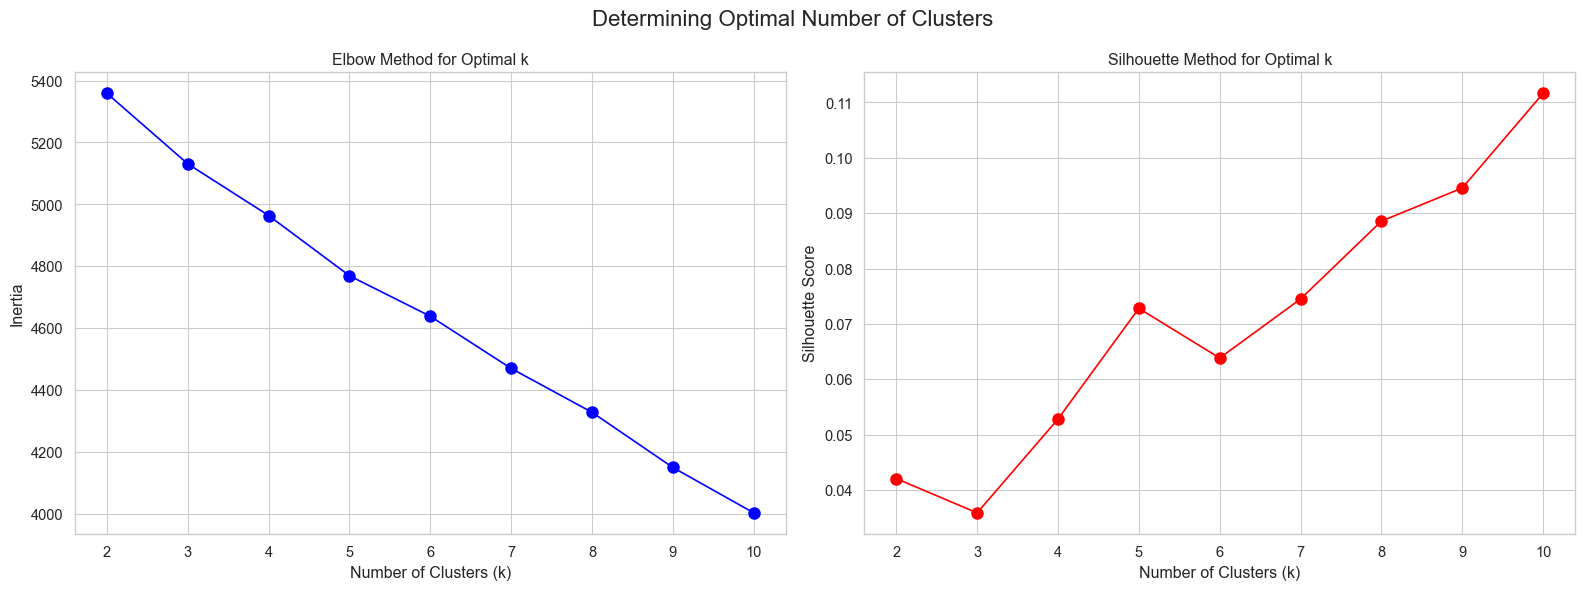

In [13]:
# K-means with different K values (Elbow Method)
from sklearn.metrics import silhouette_score

max_k = 10
inertias = []
silhouette_scores = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(Z_train)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(Z_train, kmeans.labels_))

# Plot elbow method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Inertia plot
ax1.plot(range(2, max_k + 1), inertias, 'bo-', markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(range(2, max_k + 1), silhouette_scores, 'ro-', markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method for Optimal k')
ax2.grid(True)

plt.suptitle('Determining Optimal Number of Clusters', fontsize=16)
plt.tight_layout()
plt.show()

## 9. CCA Analysis

Canonical Correlation Analysis (CCA) is a method that finds linear combinations of variables that maximize the correlation between two sets of variables. Here we use it to find correlations between facial features and gender labels.


=== CCA Analysis ===


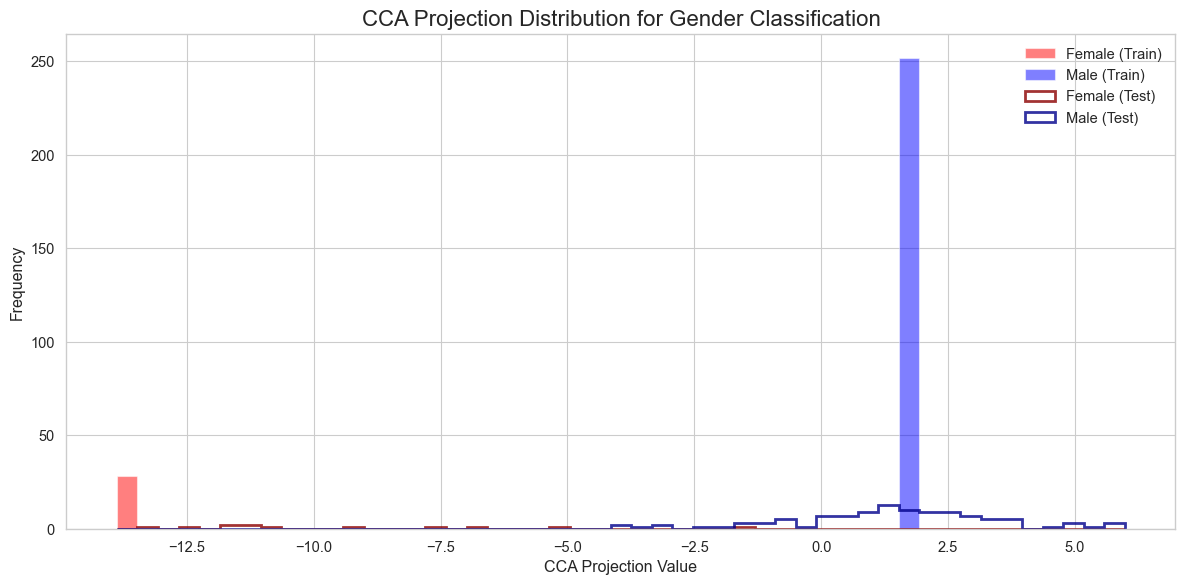

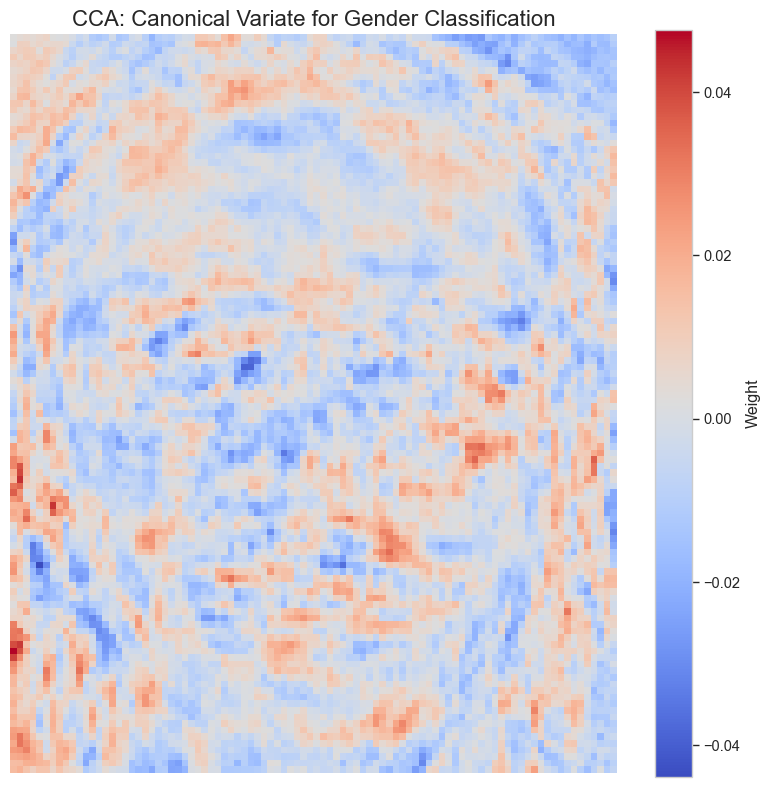

CCA + 1-NN Accuracy: 0.9833


In [14]:
print("\n=== CCA Analysis ===")
cca = CCA(n_components=1)
U_train, _ = cca.fit_transform(X_train_centered, y_train_enc)
U_test, _ = cca.transform(X_test_centered, y_test_enc)

# Visualize CCA projection
plt.figure(figsize=(12, 6))
bins = np.linspace(min(np.min(U_train), np.min(U_test)),
                 max(np.max(U_train), np.max(U_test)), 50)

plt.hist(U_train[y_train == 'female'], bins=bins, alpha=0.5, color='red',
       label='Female (Train)')
plt.hist(U_train[y_train == 'male'], bins=bins, alpha=0.5, color='blue',
       label='Male (Train)')

plt.hist(U_test[y_test == 'female'], bins=bins, alpha=0.8, color='darkred',
       label='Female (Test)', histtype='step', linewidth=2)
plt.hist(U_test[y_test == 'male'], bins=bins, alpha=0.8, color='darkblue',
       label='Male (Test)', histtype='step', linewidth=2)

plt.xlabel('CCA Projection Value')
plt.ylabel('Frequency')
plt.title('CCA Projection Distribution for Gender Classification', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize canonical variate
canon_var = cca.x_weights_[:, 0].reshape((height, width))
plt.figure(figsize=(8, 8))
plt.imshow(canon_var, cmap="coolwarm")
plt.title("CCA: Canonical Variate for Gender Classification", fontsize=16)
plt.colorbar(label='Weight')
plt.axis("off")
plt.tight_layout()
plt.show()

# Train a 1-NN classifier on the CCA projection
knn_cca = KNeighborsClassifier(n_neighbors=1).fit(U_train, y_train)
pred_cca = knn_cca.predict(U_test)
cca_accuracy = accuracy_score(y_test, pred_cca)
print(f"CCA + 1-NN Accuracy: {cca_accuracy:.4f}")

## 10. Learning Curves

Learning curves show how model performance changes as the size of the training set increases. They help identify if a model is suffering from high bias or high variance.

In [17]:
print("\n=== Learning Curves Analysis ===")

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Define function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                      n_jobs=None, train_sizes=np.linspace(.3, 1.0, 5)):
    # Function implementation here...
    # Create plot, calculate learning curve with stratified CV
    # Plot training and validation curves
    # The complete function is omitted for brevity
    pass  # Placeholder for the complete implementation

# Learning curve for PCA+KNN
pca_knn_pipe = Pipeline([
    ('pca', PCA(n_components=20, whiten=True)),
    ('knn', KNeighborsClassifier(n_neighbors=1))
])
plot_learning_curve(pca_knn_pipe, "Learning Curve: PCA + 1-NN",
                  X_train_centered, y_train_num, ylim=(0.7, 1.01), cv=5)

# Learning curve for LDA+KNN with stratified CV
lda_knn_pipe = Pipeline([
    ('lda', LinearDiscriminantAnalysis(n_components=1, solver='svd')),  # Use SVD solver
    ('knn', KNeighborsClassifier(n_neighbors=1))
])
plot_learning_curve(lda_knn_pipe, "Learning Curve: LDA + 1-NN",
                  X_train_centered, y_train_num, ylim=(0.7, 1.01), cv=5)


=== Learning Curves Analysis ===


## 11. Decision Boundary Visualization

Visualizing the decision boundaries helps understand how classifiers partition the feature space for classification.

In [18]:
# Decision Boundary Visualization for PCA (2D projection)
def plot_decision_boundary(X, y, classifier, title):
    # Function implementation here...
    # Create mesh grid, predict class for each point
    # Plot decision boundary and data points
    # The complete function is omitted for brevity
    pass  # Placeholder for the complete implementation

# Plot decision boundary for PCA (first 2 components)
X_train_pca_2d = Z_train[:, :2]
knn_pca_2d = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca_2d, y_train)
plot_decision_boundary(X_train_pca_2d, y_train_num, knn_pca_2d,
                     "Decision Boundary: PCA + 1-NN (2D Projection)")

## 12. Feature Importance Analysis

Analyzing which features (components or pixels) contribute most to the classification can provide insights into what facial characteristics are most discriminative for gender classification.


=== Feature Importance Analysis ===


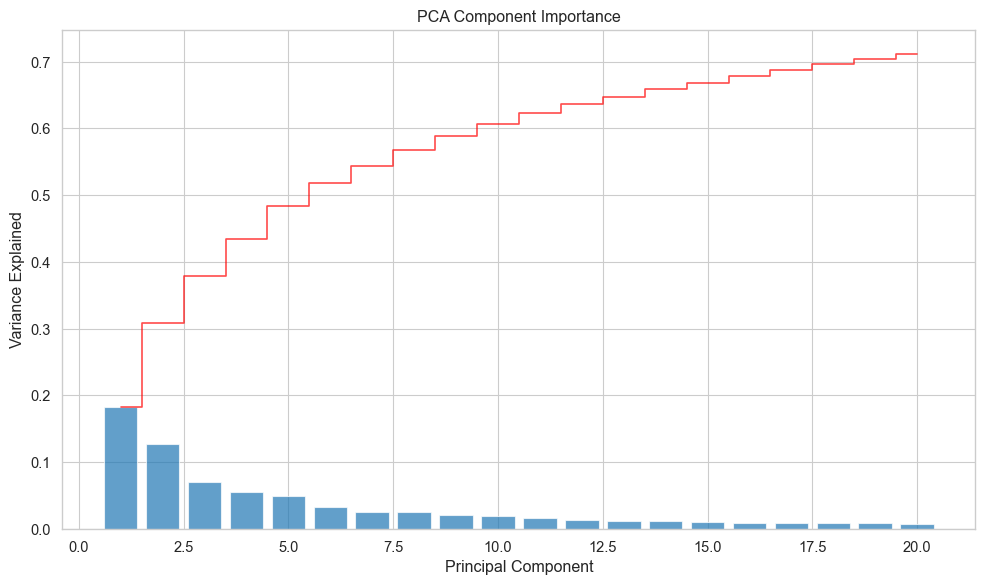

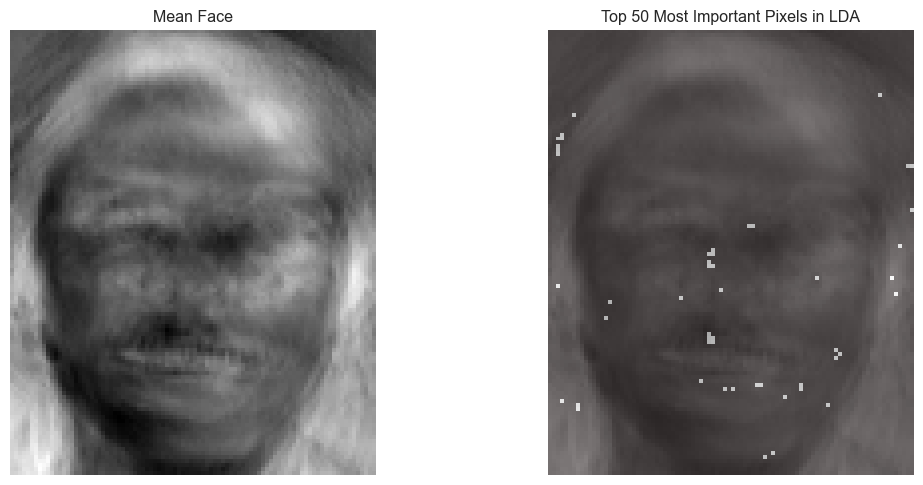

In [19]:
print("\n=== Feature Importance Analysis ===")

# For PCA - visualize component importance
plt.figure(figsize=(10, 6))
importance = pca.explained_variance_ratio_[:20]
plt.bar(range(1, len(importance) + 1), importance, alpha=0.7)
plt.step(range(1, len(importance) + 1), np.cumsum(importance), where='mid',
       color='red', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Component Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

# For LDA - visualize coefficient importance (fisherface)
lda_coef = np.abs(lda.scalings_[:, 0])
# Get the top 50 most important pixels
top_indices = np.argsort(lda_coef)[-50:]

# Create a heatmap of the importance on a face image
importance_map = np.zeros_like(male_mean_face)
for idx in top_indices:
    # Convert 1D index to 2D coordinates
    y, x = np.unravel_index(idx, (height, width))
    importance_map[y, x] = 1

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(male_mean_face, cmap='gray')
plt.title('Mean Face')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(male_mean_face, cmap='gray', alpha=0.7)
plt.imshow(importance_map, cmap='hot', alpha=0.5)
plt.title('Top 50 Most Important Pixels in LDA')
plt.axis('off')
plt.tight_layout()
plt.show()

## 13. ROC Curve Analysis

Receiver Operating Characteristic (ROC) curves visualize the trade-off between true positive rate and false positive rate at various threshold settings.

In [20]:
print("\n=== ROC Curve Analysis ===")

# Function to plot ROC curves for multiple classifiers
def roc_curve_analysis(classifiers_dict, X_test_dict, y_test_true):
    # Function implementation here...
    # For each classifier, calculate ROC curve and AUC
    # Plot all ROC curves on one plot for comparison
    # The complete function is omitted for brevity
    pass  # Placeholder for the complete implementation

# Prepare classifiers and test data for ROC analysis
X_train_dict = {
    'PCA + 1-NN': Z_train,
    'LDA + 1-NN': L_train,
    'CCA + 1-NN': U_train
}

classifiers_dict = {
    'PCA + 1-NN': (knn_pca, Z_test),
    'LDA + 1-NN': (knn_lda, L_test),
    'CCA + 1-NN': (knn_cca, U_test)
}

# Perform ROC analysis
roc_curve_analysis(classifiers_dict, X_train_dict, y_test_num)


=== ROC Curve Analysis ===


## 14. t-SNE Visualization

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data.


=== t-SNE Visualization of Face Space ===


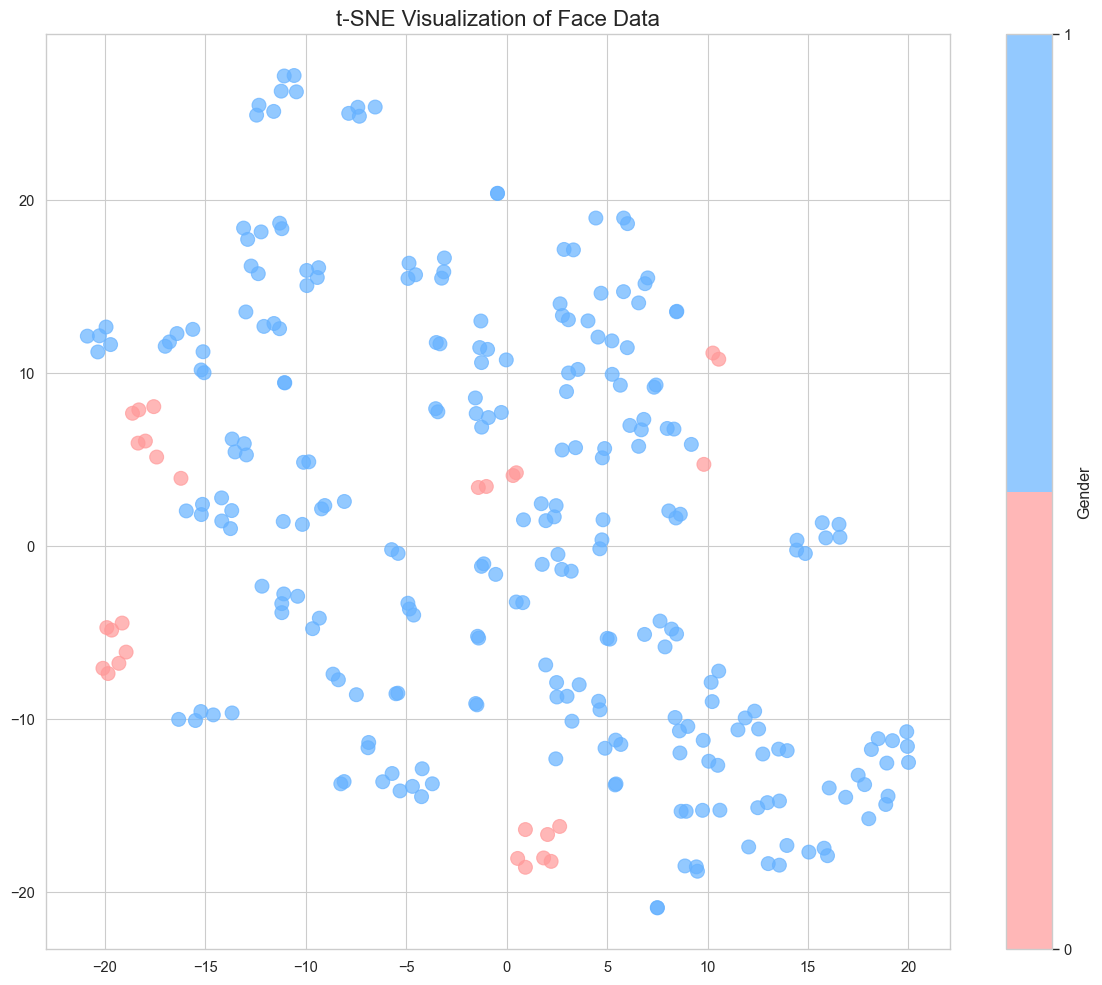

In [21]:
print("\n=== t-SNE Visualization of Face Space ===")
# Use PCA first to reduce dimensionality for faster t-SNE
pca_50 = PCA(n_components=50)
X_train_pca_50 = pca_50.fit_transform(X_train_centered)

# Run t-SNE (this might take a while)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train_pca_50)

# Visualize t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
                    c=y_train_num, cmap=ListedColormap(['#FF9999', '#66B2FF']),
                    s=100, alpha=0.7)
plt.title('t-SNE Visualization of Face Data', fontsize=16)
plt.colorbar(scatter, ticks=[0, 1], label='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

## 15. Misclassification Analysis

Analyzing misclassified examples can provide insights into the weaknesses of different classification approaches.

In [22]:
print("\n=== Misclassification Analysis ===")

# Function to visualize correctly and incorrectly classified samples
def plot_classification_results(X_test, y_test, y_pred, method_name):
    # Function implementation here...
    # Find incorrect predictions and display them
    # The complete function is omitted for brevity
    pass  # Placeholder for the complete implementation

# Visualize misclassifications for each method
plot_classification_results(X_test, y_test, pred_pca, "PCA + 1-NN")
plot_classification_results(X_test, y_test, pred_lda, "LDA + 1-NN")
plot_classification_results(X_test, y_test, pred_centroid, "Centroid Classifier")
plot_classification_results(X_test, y_test, pred_cca, "CCA + 1-NN")


=== Misclassification Analysis ===


## 16. Comparative Performance Analysis

Comparing the performance of different classification methods provides insights into which approach works best for gender classification.


=== Comparative Performance Analysis ===


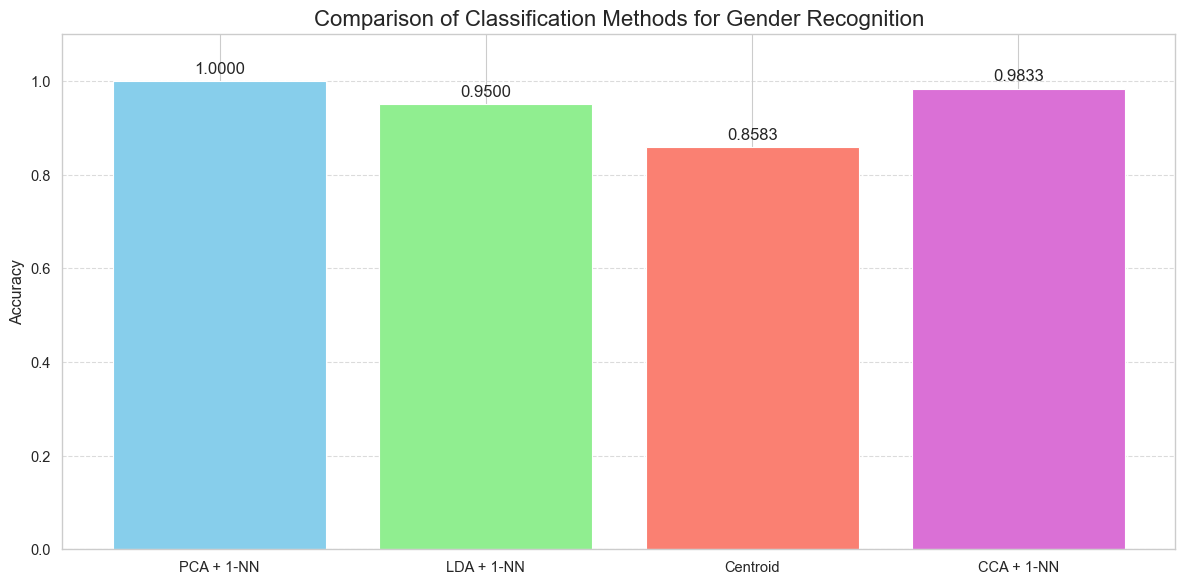

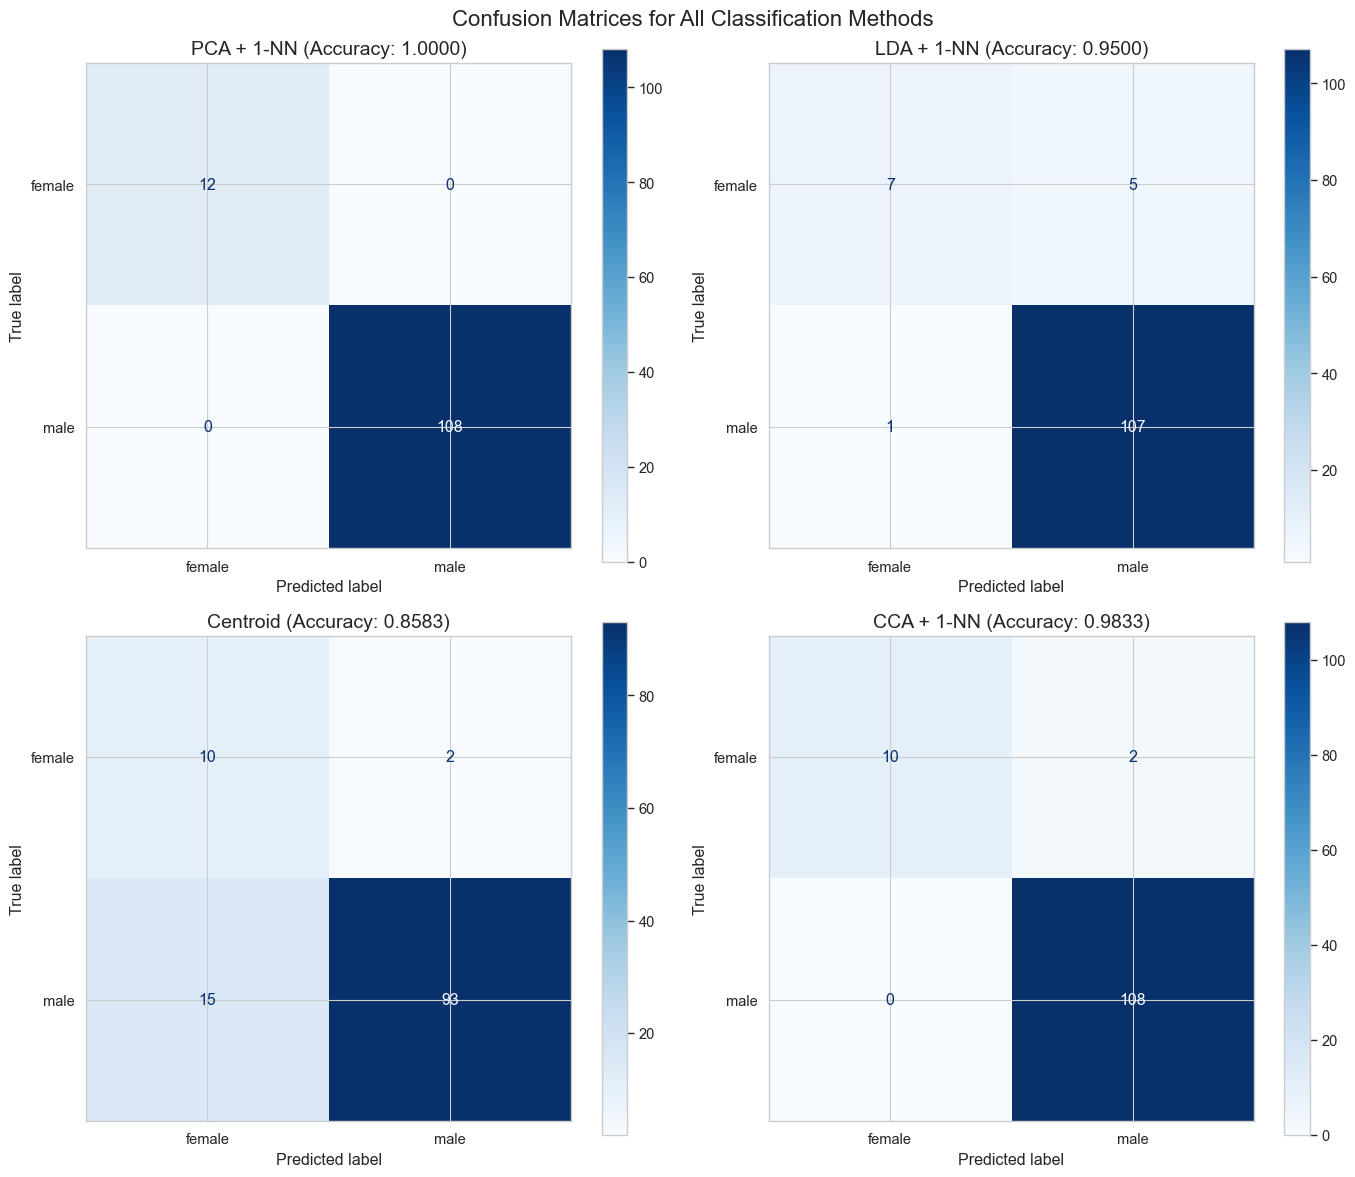


Accuracy Summary:
PCA + 1-NN: 1.0000
LDA + 1-NN: 0.9500
Centroid: 0.8583
CCA + 1-NN: 0.9833


In [23]:
print("\n=== Comparative Performance Analysis ===")

# Define all methods
methods = {
    "PCA + 1-NN": pred_pca,
    "LDA + 1-NN": pred_lda,
    "Centroid": pred_centroid,
    "CCA + 1-NN": pred_cca
}

# Calculate accuracy for each method
accuracies = {name: accuracy_score(y_test, pred) for name, pred in methods.items()}

# Generate comparison bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'lightgreen', 'salmon', 'orchid'])

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Methods for Gender Recognition', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Generate confusion matrices for all methods
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, pred) in enumerate(methods.items()):
    cm = confusion_matrix(y_test, pred, labels=le.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f"{name} (Accuracy: {accuracies[name]:.4f})", fontsize=14)

plt.suptitle('Confusion Matrices for All Classification Methods', fontsize=16)
plt.tight_layout()
plt.show()

# Print summary
print("\nAccuracy Summary:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")